## Co to za taka działka NLP?


---

Co będzie?
- tokeny, reprezentacja słów, podstawy

Czego nie będzie?
- transformery

![Czym jest NLP?](https://7wdata.be/wp-content/uploads/2021/09/DCF_NLP-in-the-Data-Center_ML-DL-Diagram.png)

## Jakie zadania rozwiązujemy w NLP

- Generowanie tekstu (artykuły, response z ChatGPT, etc...) (*Text Generation*)
- Streszczenie tekstu (*Text Summarization*)
- Identyfikacja części mowy (*POS - part-of-speech- tagging*)
- Automatyczne Odpowiadanie na Pytania (*Automatic Question Answering*)
- Identyfikacja Encji (Nazwanych) (*(Named) Entity Recognition, (N)ER*)

- ...(dużo innego).

Temat ważny, bo język naturalny - to coś, czego używamy każdego dnia do komunikacji. Dość prężnie rozwinięta działka, ale still IMO plenty of fish in the sea, bo każda firma, generuje dużo tekstu - czy w postaci raportów, dokumentów itp. - które nie zawsze są ustrukturyzowane.

Więc siłą rzeczy pojawiają się pytania jak reprezentować i przetwarzać taki tekst.

A więc... let's dive into it. Żeby modelować tekst, musimy jakoś go reprezentować

---

### Notatki

Łatwo parsować ustrukturyzowany tekst, nie potrzeba do tego sieci neuronowych

Dopiero jeśli to nam nie wystarcza to wtedy NN. Oprócz odpowiadania na pytania, można wykorzystywać to do streszczania tekstu.

encje -> klasyfikacja grup słów, które mają określone znaczenie, np opis puszczy będzie o puszczy.

## Libki

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups

import nltk # podstawowa libka do nlp

nltk.download('stopwords')
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download('punkt')

from nltk.util import ngrams
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from nltk.tokenize import word_tokenize, sent_tokenize

import re

import spacy

import numpy as np
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import locale
locale.getpreferredencoding

<function locale.getpreferredencoding(do_setlocale=True)>

In [ ]:
import locale


prev = locale.getpreferredencoding
locale.getpreferredencoding = lambda: "UTF-8"


!python -m spacy download en_core_web_sm

locale.getpreferredencoding = prev

2023-04-01 08:23:52.462049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 46.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
prev

<function locale.getpreferredencoding(do_setlocale=True)>

## Jak reprezentować tekst

### OneHotEncoding

Najprostszy sposób na reprezentację tekstu.
Jak to robimy:
1. Tworzymy słownik ze słowami zawierającymi się w naszym zbiorze $$V=(word_1, word_2, ..., word_n)$$

2. Reprezentujemy tekst jako wektory $$vect = (a_1, a_2, ..., a_{|V|})$$, gdzie 

$$a_i = \left\{\begin{array}{rcl}
0 \space gdy \space słowo_i \notin Tekst\\
1 \space gdy \space słowo_i \in Tekst
\end{array} \right.$$


V - słownik, vect - reprezentacja

In [ ]:
def create_vocab(text):
    words = text.split()
    vocab = list(set(words))
    return vocab


def encode_text(text, vocab):
    text_words = set(text.split())
    return [word in text_words for word in vocab]

In [ ]:
text = "Ted jest trenerem"
text2 = "Leo nie jest trenerem"

vocab = create_vocab(text)
encode_text(text2, vocab), vocab

([True, False, True], ['trenerem', 'Ted', 'jest'])

### Bag of Words

Wadą naszego porzedniego rozwiązania jest to, że tylko sprawdza czy słowo wystąpiło, dlatego teraz dodatkowo będziemy zliczali liczbę wystąpień słów.

1. Ponownie tworzymy słownik ze słowani w zbiorze $$ V = (słowo_1, słowo_2, ... , słowo_n) $$

2. Reprezentujemy tekst na podstawie wektora wystąpień słów:
$$ vect = (a_1, a_2, ..., a_{|V|})$$
$$ a_i - liczba \space wystąpień \space słowa_i \space w \space tekście $$

again, V - słownik, vect - reprezentacja

---

wektory z liczebnością mają usprawnić one-hot żeby wektory były krótsze. Sumowanie wektorów na każde słowo w zdaniu

In [ ]:
twenty_train = fetch_20newsgroups(
    subset="train", shuffle=True, random_state=42
)

In [ ]:
vectorizer = CountVectorizer().fit(twenty_train.data)

In [ ]:
vectorizer.vocabulary_

In [ ]:
transformed = vectorizer.transform(twenty_train.data[:1])

In [ ]:
transformed # sparse matrix bo bedzie wiele zer (macierz rzadka) reprezentacja jakie slowa wystapily w danym paragrafie. 
            # Wrzucamy liczbe wystapien w calym treningowym zbiorze na pozycji danego słowa z paragrafu

<1x130107 sparse matrix of type '<class 'numpy.int64'>'
	with 89 stored elements in Compressed Sparse Row format>

In [ ]:
twenty_train.data[:1]

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"]

### TF-IDF (Term Frequency - Inverse Document Frequency)

Nowa wersja zliczania - faworyzujemy słowa, które występują częściej w pojedyńczym dokumencje, a rzadziej w całym korpusie dokumentów.


$$tf(t,d) = \frac{f_{t,d}}{\sum_{t'∈d}{f_{t',d}}}$$

$$idf(t, D) = log \frac{N}{\{d \in D; t \in d \}}$$

$$ tfidf(t, d, D) = tf(t, d) * idf(t, D)$$


t - słowo, d - dokument, D - korpus dokumentów

'Ala ma kota'
'Anton nie ma'

dla `ma`:
  tf = $\frac{1}{3}$

  idf = log N/alpha = log 2/2 = log 1 = 0

  N to liczba dokumentow w korpusie 
  aplha to liczba dokumentow w ktorych wystepuje nasz token

  ifidf = 1/3 * 0 = 0


In [ ]:
vectorizer = TfidfVectorizer().fit(twenty_train.data)
transformed_data = vectorizer.transform(twenty_train.data)

In [ ]:
transformed_data

<11314x130107 sparse matrix of type '<class 'numpy.float64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

### Zadanko

Korzystając z reprezentacji CountVectorizer, TF-IDF nauczyć drzewo losowe dla przewidywania klasy wiadomości

In [ ]:
twenty_test = fetch_20newsgroups(subset="test", shuffle=True, random_state=42)
train_text, train_class = twenty_train.data, twenty_train.target
test_text, test_class = twenty_test.data, twenty_test.target

In [ ]:
train_class

array([7, 4, 4, ..., 3, 1, 8])

In [38]:
# Tutaj rozwiązanie
from sklearn import tree
clf = tree.DecisionTreeClassifier()

vectorizer = TfidfVectorizer().fit(train_text)
transformed_data = vectorizer.transform(train_text)

clf.fit(transformed_data, train_class)

prediction = clf.predict(vectorizer.transform(test_text))

In [39]:
tmp = prediction == test_class
print(tmp.sum() / prediction.shape[0] * 100)

#########

from sklearn.metrics import accuracy_score  # prostszy sposób oceniania xd
acc = accuracy_score(test_class, prediction)

print(f"Accuracy: {acc}")
# dobry baseline na początek żeby mieć co przebijać

55.73552841210834
Accuracy: 0.5573552841210834


### N - gramy

Czasem istotną informację mogą zawierać ciągi słów. Modelujemy zdania w postaci N - gramów - ciągów N słów.



Przykład:

Zdanie: Ala ma kapibarę.

2-gram: ['Ala', 'ma'], ['ma', 'kapibarę']

In [40]:
text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud "

In [41]:
# funckja ngrams wymaga podania na wejście sekwencji
list(ngrams(text.split(), 3))

[('Lorem', 'ipsum', 'dolor'),
 ('ipsum', 'dolor', 'sit'),
 ('dolor', 'sit', 'amet,'),
 ('sit', 'amet,', 'consectetur'),
 ('amet,', 'consectetur', 'adipiscing'),
 ('consectetur', 'adipiscing', 'elit,'),
 ('adipiscing', 'elit,', 'sed'),
 ('elit,', 'sed', 'do'),
 ('sed', 'do', 'eiusmod'),
 ('do', 'eiusmod', 'tempor'),
 ('eiusmod', 'tempor', 'incididunt'),
 ('tempor', 'incididunt', 'ut'),
 ('incididunt', 'ut', 'labore'),
 ('ut', 'labore', 'et'),
 ('labore', 'et', 'dolore'),
 ('et', 'dolore', 'magna'),
 ('dolore', 'magna', 'aliqua.'),
 ('magna', 'aliqua.', 'Ut'),
 ('aliqua.', 'Ut', 'enim'),
 ('Ut', 'enim', 'ad'),
 ('enim', 'ad', 'minim'),
 ('ad', 'minim', 'veniam,'),
 ('minim', 'veniam,', 'quis'),
 ('veniam,', 'quis', 'nostrud')]

Wszystkie wcześniej wymienione sposoby reprezentacji tekstu domyślnie operują na słowach ale mogą operować też na n-gramach

In [42]:
vectorizer = CountVectorizer(ngram_range=(1, 2)).fit(["Ala ma psa"])
transformed = vectorizer.transform(
    ["Indra ma psa i ma wiele kotów, które nie lubią psów"]
)

In [43]:
vectorizer.get_feature_names_out()

array(['ala', 'ala ma', 'ma', 'ma psa', 'psa'], dtype=object)

In [44]:
transformed.toarray()

array([[0, 0, 2, 1, 1]])

Analogicznie jest dla TF-IDF

### Back to Zadanko

Przetestujcie N - gramy do zadania (**IMPORTANT** - Nie przesadźcie z N, bo wam RAM zabije).

In [45]:
twenty_test = fetch_20newsgroups(subset="test", shuffle=True, random_state=42)
train_text, train_class = twenty_train.data, twenty_train.target
test_text, test_class = twenty_test.data, twenty_test.target

In [51]:
# Tutaj rozwiązanie
tfidf = TfidfVectorizer(ngram_range=(1, 5)).fit(train_text)
transformed_train = tfidf.transform(train_text)
transformed_test = tfidf.transform(test_text)

In [52]:
transformed_train.shape # warto sprawdzać wymiarowość, żeby wiedzieć czego się można spodziewać 

(11314, 8069416)

In [53]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(transformed_train, train_class)

predictions = dtree.predict(transformed_test)

In [54]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(test_class, predictions)

print(f"accuracy: {acc * 100:.6f}")

accuracy: 55.138078


### Zmniejszanie słownika

#### Stop words

W każdym języku są takie słowa, które nie niosą żadnej informacji. Chcemy czasem takich slów pozbyć (zmniejszenie wymiaru słownika)

Przykłady:

Angielski: "a", "which", "who"

Polski: "i", "a", "kto", "ja"

In [ ]:
stops = set(stopwords.words("english")) # usuwanie szumu, bo przyimki itp nie dodają nam informacji

In [ ]:
stops

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

#### Stemming i Lemmatyzacja

Czasem nie interesuje nas odmiana słowa, tylko czy samo słowo wystąpiło. 

Np. chcemy wyszukać niezależnie od odmiany jakiekolwiek wystąpienie słowa. Wtedy dokonujemy **stemmingu** (usunięcia ostatnich liter słówa), lub **lemmatyzacji** (przywrócenia słowa do początkowej formy)

In [ ]:
lemmatizer = WordNetLemmatizer()  # skrocenie do bezokolicznika, raczej poprawne
stemmer = PorterStemmer()         # najwieksza zgodnosc, moze byc srednie 

In [ ]:
stemmer = PorterStemmer()
words = [
    "caresses",
    "flies",
    "dies",
    "mules",
    "denied",
    "died",
    "agreed",
    "owned",
    "humbled",
    "sized",
    "meeting",
    "stating",
    "siezing",
    "itemization",
    "sensational",
    "traditional",
    "reference",
    "colonizer",
    "plotted",
]
for word in words:
    lemmatized, stemmed = lemmatizer.lemmatize(word), stemmer.stem(word)
    print(f"\nOG word: {word}\nLemma: {lemmatized}\nStemmed:{stemmed}")


OG word: caresses
Lemma: caress
Stemmed:caress

OG word: flies
Lemma: fly
Stemmed:fli

OG word: dies
Lemma: dy
Stemmed:die

OG word: mules
Lemma: mule
Stemmed:mule

OG word: denied
Lemma: denied
Stemmed:deni

OG word: died
Lemma: died
Stemmed:die

OG word: agreed
Lemma: agreed
Stemmed:agre

OG word: owned
Lemma: owned
Stemmed:own

OG word: humbled
Lemma: humbled
Stemmed:humbl

OG word: sized
Lemma: sized
Stemmed:size

OG word: meeting
Lemma: meeting
Stemmed:meet

OG word: stating
Lemma: stating
Stemmed:state

OG word: siezing
Lemma: siezing
Stemmed:siez

OG word: itemization
Lemma: itemization
Stemmed:item

OG word: sensational
Lemma: sensational
Stemmed:sensat

OG word: traditional
Lemma: traditional
Stemmed:tradit

OG word: reference
Lemma: reference
Stemmed:refer

OG word: colonizer
Lemma: colonizer
Stemmed:colon

OG word: plotted
Lemma: plotted
Stemmed:plot


## Regexes

Regex czyli regular expressions to narzędzie pozwalające tworzyć wzorce tekstowe, które potem można wykorzystać np. do usuwania konkretnych wzorców z tekstu w celu filtorwania, wyciąganie emaili z tekstu itd.



*jak można do czegoś nie używać ML, to tak zrób*


In [55]:
# Tak się tworzy regexa
pattern = re.compile(r"@gmail.com")

pattern.findall("kasjhfgasil email_1@gmail.com jfalfhjas lfhaklfj pw@gmail.com")

['@gmail.com', '@gmail.com']

![regex_cheatsheet](https://camo.githubusercontent.com/5b07dee12415da23202b61c7741ab5eeaebe2842f2527ef4a28ddb0ed2a15216/68747470733a2f2f6d656469612e63686561746f6772617068792e636f6d2f73746f726167652f7468756d622f646176656368696c645f726567756c61722d65787072657373696f6e732e3735302e6a7067)

funkcje:

- **findall**: znajduje wszystkie wystąpienia wzorca
- **search**: zwraca None albo pierwsze wystąpienie wzorca
- **split** - rozdziela po wzorcu
- **sub** - zastępuje po wzorcu


In [57]:
pattern = re.compile(r"[\w]+@[\w\.]+")

text = "something some_email11234@gmail.com someomeabaobdoaboabo supermail@elkapwedupl.com adad"
pattern.findall(text)

['some_email11234@gmail.com', 'supermail@elkapwedupl.com']

### Zadanko

Zadanie: stworzyć regex który wyciąga **numery telefonów komórkowych** z tekstu

In [60]:
# Tutaj rozwiązanie
pattern = re.compile(r"\+48[ -]\d{3}[ -]\d{3}[- ]\d{3}")
to_search = "asoihfjaos hoasuf oajioah ofijoe pw@edu.pl +48 830 850 103 klajshflakshfjklaj +48-830-391-193 lfhasnoirhj weaoijpoa m +48 579 585 930"
pattern.findall(to_search)

['+48 830 850 103', '+48-830-391-193', '+48 579 585 930']

### Zastępowanie grup

**Grupy**

In [63]:
to_search = "asoihfjaos hoasuf asbsc@pavw.et oajioah ofijoe pw@edu.pl +48 830 850 103 klajshflakshfjklaj 7830-391-193 lfhasnoirhj weaoijpoa m +375 29 840 91 41"

regex_with_group = r"(\w+)@([\w\.]+)"
re.findall(regex_with_group, to_search)

re.search(regex_with_group, to_search).group(0) # 0 - cały match, 1 - 1 elem, 2 - 2 elem

'asbsc@pavw.et'

In [ ]:
re.sub(regex_with_group, "\\1@uganda.ug", to_search) # first group and something

'asoihfjaos hoasuf asbsc@uganda.ug oajioah ofijoe pw@uganda.ug +48 830 850 103 klajshflakshfjklaj 7830-391-193 lfhasnoirhj weaoijpoa m +375 29 840 91 41'

In [ ]:
re.sub(regex_with_group, "auuuuuu@\\2", to_search) # something and the rest is the second group

'asoihfjaos hoasuf auuuuuu@pavw.et oajioah ofijoe auuuuuu@edu.pl +48 830 850 103 klajshflakshfjklaj 7830-391-193 lfhasnoirhj weaoijpoa m +375 29 840 91 41'

In [ ]:
regex_with_group = r"(\w+)@(?:[\w\.]+)"
re.findall(regex_with_group, to_search)

['asbsc', 'pw']

### Resources for regexes




- [Generowanie Regexów z tekstu](https://www.autoregex.xyz/)
- [Łatwe sprawdzanie regexów](https://regex101.com/)

## Biblioteka spaCy do problemów lingwistycznych

spaCy jest biblioteką zawierającą wiele modeli do problemów lingwistycznych, które teraz sobie krótko omówimy.

In [65]:
# wczytywanie modelu językowego
nlp = spacy.load("en_core_web_sm")
doc = nlp("Akash has been buyed by byju's in 73,000 Core's") # tworzy tokeny
for token in doc:
    print(token.text)


Akash
has
been
buyed
by
byju
's
in
73,000
Core
's


### Part-Of_Speech (POS) - tagging

problem ten polega na wyjaśnieniu w jaki sposób dane słowo jest wykorzystane w zdaniu. Ustalone jest 8 części mowy (po ang bo będzie łatwiej):

- Noun
- Pronoun
- Adjective
- Verb
- Adverb
- Preposition
- Conjunction
- Interjection

In [66]:
doc = nlp("I am Anshul ,currently a Computer Science student and a Machine Learning Engineer")

# Iterate over the tokens
for token in doc:
    # Print the token and its part-of-speech tag
    print(token, token.tag_, token.pos_, spacy.explain(token.tag_))

I PRP PRON pronoun, personal
am VBP AUX verb, non-3rd person singular present
Anshul NNP PROPN noun, proper singular
, , PUNCT punctuation mark, comma
currently RB ADV adverb
a DT DET determiner
Computer NNP PROPN noun, proper singular
Science NNP PROPN noun, proper singular
student NN NOUN noun, singular or mass
and CC CCONJ conjunction, coordinating
a DT DET determiner
Machine NNP PROPN noun, proper singular
Learning NNP PROPN noun, proper singular
Engineer NNP PROPN noun, proper singular


In [67]:
doc = nlp("I am Anshul ,currently a Computer Science student and a Machine Learning Enginee")
spacy.displacy.render(doc, style="dep", jupyter=True)

### Named Entity Recognition

In [68]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(
    "Reliance is looking at buying U.K. based analytics startup for $7 billion"
)
# See the entity present
print(f"Enitites: {doc.ents}")
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_) # jakies znane i juz zakodowane encje

Enitites: (Reliance, U.K., $7 billion)
Reliance 0 8 ORG
U.K. 30 34 GPE
$7 billion 63 73 MONEY


### Entity Recogniton

nazywane też Entity Detection jest bardziej zaawansowany od NER, ponieważ rozpoznaje istotne elementy między innymi miejsca, ludzi, organizacje, języki itp.

(Śmieszne, że Amazon - to raczej organizacja niż miejsce na Ziemi).

In [71]:
nlp = spacy.load("en_core_web_sm") # spacy model, abstrakcja na modele z tokenizer, (pipeline) który upraszcza funkcje, pos, podstawowe formy, regexy itd
# dobre do baselinu :D
doc = nlp(
    u"""The Amazon rainforest,[a] alternatively, the Amazon Jungle, also known in English as Amazonia, is a moist broadleaf tropical rainforest in the Amazon biome that covers most of the Amazon basin of South America. This basin encompasses 7,000,000 km2 (2,700,000 sq mi), of which 5,500,000 km2 (2,100,000 sq mi) are covered by the rainforest. This region includes territory belonging to nine nations.

The majority of the forest is contained within Brazil, with 60% of the rainforest, followed by Peru with 13%, Colombia with 10%, and with minor amounts in Bolivia, Ecuador, French Guiana, Guyana, Suriname, and Venezuela. Four nations have "Amazonas" as the name of one of their first-level administrative regions and France uses the name "Guiana Amazonian Park" for its rainforest protected area. The Amazon represents over half of the planet's remaining rainforests,[2] and comprises the largest and most biodiverse tract of tropical rainforest in the world, with an estimated 390 billion individual trees divided into 16,000 species.[3]

Etymology
The name Amazon is said to arise from a war Francisco de Orellana fought with the Tapuyas and other tribes. The women of the tribe fought alongside the men, as was their custom.[4] Orellana derived the name Amazonas from the Amazons of Greek mythology, described by Herodotus and Diodorus.[4]

History
See also: History of South America § Amazon, and Amazon River § History
Tribal societies are well capable of escalation to all-out wars between tribes. Thus, in the Amazonas, there was perpetual animosity between the neighboring tribes of the Jivaro. Several tribes of the Jivaroan group, including the Shuar, practised headhunting for trophies and headshrinking.[5] The accounts of missionaries to the area in the borderlands between Brazil and Venezuela have recounted constant infighting in the Yanomami tribes. More than a third of the Yanomamo males, on average, died from warfare.[6]"""
)

entities = [(i, i.label_, i.label) for i in doc.ents]
entities

[(Amazon, 'ORG', 383),
 (Amazon, 'ORG', 383),
 (Jungle, 'PRODUCT', 386),
 (English, 'LANGUAGE', 389),
 (Amazonia, 'GPE', 384),
 (Amazon, 'ORG', 383),
 (Amazon, 'ORG', 383),
 (South America, 'LOC', 385),
 (7,000,000, 'CARDINAL', 397),
 (2,700,000 sq mi, 'QUANTITY', 395),
 (5,500,000, 'CARDINAL', 397),
 (2,100,000 sq mi, 'QUANTITY', 395),
 (nine, 'CARDINAL', 397),
 (Brazil, 'GPE', 384),
 (60%, 'PERCENT', 393),
 (Peru, 'GPE', 384),
 (13%, 'PERCENT', 393),
 (Colombia, 'GPE', 384),
 (10%, 'PERCENT', 393),
 (Bolivia, 'GPE', 384),
 (Ecuador, 'GPE', 384),
 (French, 'NORP', 381),
 (Guiana, 'PERSON', 380),
 (Guyana, 'GPE', 384),
 (Suriname, 'GPE', 384),
 (Venezuela, 'GPE', 384),
 (Four, 'CARDINAL', 397),
 (Amazonas, 'PERSON', 380),
 (one, 'CARDINAL', 397),
 (first, 'ORDINAL', 396),
 (France, 'GPE', 384),
 (Guiana Amazonian Park, 'WORK_OF_ART', 388),
 (Amazon, 'ORG', 383),
 (over half, 'CARDINAL', 397),
 (rainforests,[2, 'PRODUCT', 386),
 (an estimated 390 billion, 'MONEY', 394),
 (16,000, 'CARDI

In [70]:
spacy.displacy.render(doc, style="ent", jupyter=True)

## Tokenizacja

Jak tworzyć tokeny z tekstu - pomysły:
- Oddzielamy spacjami
- Znakami interpunkcyjnymi
- regexy (np. 'doesn't' => ("does", "n't") - 2 tokeny)

---

bardzo rozszerza nam słownik problemem są bardzo długie wyrazy


In [ ]:
word_tokenize("Doesn't this guitar sound so cool?")

['Does', "n't", 'this', 'guitar', 'sound', 'so', 'cool', '?']

### Subwords tokenization

Poprzednie reprezentacje bazują na całych słowach.

Ma to parę problemów:
1. Nie wiadomo co robić ze słowami, które się nie znalazły w słowniku (najczęściej je się zastępuje pustym ciągiem "")
2. Wymiarowość słownika jest bbb duża

Z rozwiązaniem przychodzą reprezentacje, które bazują nie na samych słowach, tylko na ich fragmentach.

Pozostaje pytanie jak wybierać ciągi znaków, które będą tokenami.

Aktualnie wszystkie SOTA modele korzystają właśnie z takich tokenizacji - warto się temu przyjrzeć.

---
zmniejszając liczbę słów zmniejsza się również liczba tokenów

In [74]:
prev

<function locale.getpreferredencoding(do_setlocale=True)>

In [ ]:
import locale


prev = locale.getpreferredencoding
locale.getpreferredencoding = lambda: "UTF-8"

!pip install transformers datasets evaluate sacremoses huggingface_hub

locale.getpreferredencoding = prev

In [75]:
prev

<function locale.getpreferredencoding(do_setlocale=True)>

In [76]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer.tokenize("I have a new GPU!")

['i', 'have', 'a', 'new', 'gp', '##u', '!']

In [77]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace


tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(
    special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"], # unk unknown, sep separator, pad padding
    vocab_size=2022,
    min_frequency=1,
)

with open("tokenizer_train.txt", "w") as f:
    for line in twenty_train.data[:100]:
        f.write(line + "\n")

In [78]:
tokenizer.train(["tokenizer_train.txt"], trainer)

In [79]:
tokenizer.encode("Time to tokenize!!!.").tokens

['Tim', 'e', 'to', 'to', 'k', 'en', 'ize', '!!', '!', '.']

Wiele różnych rzeczy można robić z biblioteką [tokenizers](https://huggingface.co/docs/tokenizers/python/latest/) (Dodawanie specjalnych tokenów na początek i na koniec, pretokenizatory, mnóstwo gotowych tokenizatorów).

---

`huggingface` bardzo dużo materiałów o wszystkim związanym z transformerami

## Reprezentacje słów

### Word2Vec

![word2vec](https://jalammar.github.io/images/word2vec/word2vec.png)

### Podobieństwo słów

Mając embeddingi słów można badać ich podobieństwo badając ich odległość w przestrzeni, w której się znajdują. Najczęściej wykorzystuje się do tego odległość cosinusową

$$cosine\_similarity(A, B) = \frac{A * B}{||A|| * ||B||} = cos(\theta)$$


Oznacza kąt pomiędzy wektorami.
Kąt 0 -> cos(0) = 1 -> wektory skierowane w tę samą stronę i podobieństwo największe.


Dla Word2vec, żeby przedstawić ideę, wczytam gotowe embeddingi, które można pobrać [tutaj](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g)

In [81]:
prev

<function locale.getpreferredencoding(do_setlocale=True)>

In [80]:
from gensim.models import KeyedVectors

from google.colab import drive
drive.mount('/content/drive/')

filename = "/content/drive/MyDrive/GoogleNews-vectors-negative300.bin" # ~ 3gb
model = KeyedVectors.load_word2vec_format(filename, binary=True)

result = model.most_similar(
    positive=["woman", "king"], negative=["man"], topn=1 # + woman, king - man => queen
)
print(result)

MessageError: ignored

### Zabawy z arytmetyką Word2vec

In [ ]:
print(model.most_similar(positive=["woman", "king"], negative=["man"], topn=10))
print(model.most_similar(positive=["Paris", "Germany"], negative=["France"], topn=10))

NameError: ignored

### Wizualizacja Word2Vec

In [82]:
from sklearn.manifold import TSNE
countries = [
    "France",
    "Germany",
    "Italy",
    "Spain",
    "USA", 
    "Canada",
    "Mexico",
    "Brazil",
    "Argentina",
    "China",
    "Japan",
    "Korea",
    "India",
    "Australia",
    "Fiji",
    "Uganda",
    "Tanzania",
    "Kenya",
    "Egypt",
    "Tunisia",
    "Israel",
    "Taiwan",
    "Vietnam",
    "Thailand",
    "Laos",
    "Mongolia",
    "Pakistan",
    "Arabia",
    "Belarus",
    "Ukraine",
    "Lithuania",
    "Poland",
    "Denmark",
    "Sweden",
    "Norway",
    "Colombia",
    "Peru",
    "Paraguay"
]

vectors = []
for country in countries:
    vectors.append(model[country])
vectors = np.array(vectors)

tsne = TSNE(n_components=2, random_state=0, perplexity=10)
vectors_2d = tsne.fit_transform(vectors)

plt.figure(figsize=(10, 8))
for i, country in enumerate(countries):
    x, y = vectors_2d[i, :]
    plt.scatter(x, y)
    plt.annotate(country, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show() 

NameError: ignored

Resouces:
- [Illustrated Word2vec](https://jalammar.github.io/illustrated-word2vec/)

### Fasttext

Fasttext jest biblioteką podobnie dostarczającą embeddingi do słów jak Word2vec.

W czym pomaga **fasttext**?

W Word2vec tworzymy embeddingi pojedyńczych słów, nie jesteśmy w stanie otrzymać słowa spoza naszego słownika.

Fasttext podchodzi inaczej: słowa, które są do siebie podobne (co do odległości edycyjnej) powinny mieć podobne embeddingi.

Postanowiono je tworzyć na podstawie n-gramów na znakach (n od 3 do 6).

Preprocessing:
1. Dodajemy na początek słowa '<' a na koniec '>'.

![](https://camo.githubusercontent.com/a6b3a68750abc738ebf32e5137a012b94e22ca8af965ac8375e35718c4ef92ca/68747470733a2f2f616d69746e6573732e636f6d2f696d616765732f66617374746578742d616e67756c61722d627261636b6574732e706e67)

2. tworzymy n-gramy dla słowa
3. Trenowane jest B (B-bucket size - hiperparametr) n-gramów (Liczba wszystkich jest ogromna). Każdy n-gram jest przetwarzany funkcją hashującą do liczby całkowitej ∈ [1, B].

4. Do słownika dodajemy słowa występujące w zbiorze treningowym. Mamy B + |V| embeddingów.



**Jak trenowany jest fasttext?**

Embeddingi są trenowane wykorzystując skip-gram z negatywnym próbkowaniem. Czyli na podstawie słowa chcemy przewidzieć słowa sąsiadujące. Ale embedding słowa na podstawie, którego chcemy przewidywać to suma n-gramów i embeddingu tego słowa.

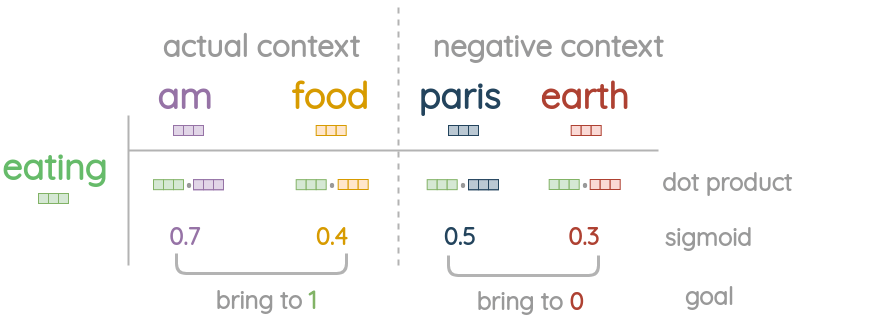


word2vec + subwordy

## Real task

In [86]:
import locale


prev = locale.getpreferredencoding
locale.getpreferredencoding = lambda: "UTF-8"

!pip install transformers datasets evaluate sacremoses huggingface_hub
locale.get_preferredencoding = prev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [88]:
# Huggingface stuff
from transformers import AutoTokenizer
# from datasets import Dataset, DatasetDict
# import evaluate

import seaborn as sns

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

from collections import Counter

import os

import pandas as pd
import numpy as np



SPLIT_RANDOM_STATE = 42

In [ ]:
BASE_DIR = "/content/drive/MyDrive/bootcamp_level_up"

with open(os.path.join(BASE_DIR, 'data', 'training_set_clean_only_text.txt'), 'r', encoding='utf-8') as f:
    feature_lines = [line.strip() for line in f.readlines()]

with open(os.path.join(BASE_DIR, "data", "training_set_clean_only_tags.txt"), 'r', encoding='utf-8') as f:
    label_lines = [line.strip() for line in f.readlines()]


In [ ]:
print(len(label_lines))
print(len(feature_lines))

In [ ]:
dataset = pd.DataFrame({'text': feature_lines, 'labels': label_lines})
dataset.labels = dataset.labels.astype('int')

In [ ]:
dataset['labels'].value_counts()

### Data Preprocessing

In [ ]:
def preprocess_text(value: str) -> str:
    """
    Removing words that start from @ (nicknames)
    as well as the newlines
    And replacing \\" (encoded) with the "

    :param value: text to clean
    
    :returns: cleaned text
    """

    words = value.split(' ')
    new_string = " ".join([word if not word.startswith('@') and len(word) > 0 else "" for word in words]).strip()

    return new_string.replace('\\n', " ").replace('\\"', '"')

### Baseline Model - CountVectorizer + LogReg

In [ ]:
X = dataset['text'].str.lower()
y = dataset['labels']

vect_dataset = pd.concat([X, y], axis=1)

train_set = vect_dataset.sample(frac=0.8, random_state=SPLIT_RANDOM_STATE)
val_set = vect_dataset[~vect_dataset.index.isin(train_set.index)]

X_train, y_train = train_set['text'], train_set['labels']
X_val, y_val = val_set['text'], val_set['labels']

vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)

In [ ]:
clf = LogisticRegression(class_weight='balanced', max_iter=10000)

clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_val)
accuracy = balanced_accuracy_score(y_val, y_pred) # do obsluzenia niezbalansowanego zbioru danych

print(f"Balanced accuracy: {round(100 * accuracy, 2)}%")

In [ ]:
cf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(cf_matrix, annot=True)

### BERT embeddings + LogReg

### Data Preparation for BERT


In [ ]:
def tokenize_function(tokenizer, examples):
    return tokenizer(examples["text"].to_list(), padding="max_length", truncation=True)['input_ids']

def tokenize_pandas(tokenizer, train_set, val_set):

    tokenized_train = tokenize_function(tokenizer, train_set)
    tokenized_val = tokenize_function(tokenizer, val_set)
    
    # type(tokenized_train)
    tokenized_train_df = pd.concat([pd.DataFrame(tokenized_train).reset_index(drop=True), train_set['labels'].reset_index(drop=True)], axis=1)
    tokenized_val_df = pd.concat([pd.DataFrame(tokenized_val).reset_index(drop=True), val_set['labels'].reset_index(drop=True)], axis=1)

    return tokenized_train_df, tokenized_val_df

def scale(tokenized_train_df, tokenized_val_df):
    scaler = StandardScaler()

    train_X, train_y = tokenized_train_df.drop('labels', axis=1), tokenized_train_df['labels']
    val_X, val_y = tokenized_val_df.drop('labels', axis=1), tokenized_val_df['labels']

    train_X_columns = train_X.columns
    val_X_columns = val_X.columns

    scaler.fit(train_X)
    train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X_columns)
    val_X = pd.DataFrame(scaler.transform(val_X), columns=val_X_columns)

    return train_X, train_y, val_X, val_y

In [ ]:
TOKENIZER_NAME = "allegro/herbert-base-cased"

herbert_tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

train_set = dataset.sample(frac=0.8, random_state=42)
val_set = dataset[~dataset.index.isin(train_set.index)]

train_set, val_set = tokenize_pandas(herbert_tokenizer, train_set, val_set)
train_X, train_y, val_X, val_y = scale(train_set, val_set)

In [ ]:
print(train_y.value_counts())
print(val_y.value_counts())

In [ ]:
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(train_X, train_y)

preds = model.predict(val_X)

bal_acc = balanced_accuracy_score(val_y, preds)

print(f"Balanced accuracy: {round(100 * bal_acc, 2)}%")

In [ ]:
cf_matrix = confusion_matrix(val_y, preds)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

### Now with added weights

In [ ]:
freqs = dict(Counter(train_set['labels'])).values()
N_CLASSES = len(set(train_set['labels']))

global_weights = {i: len(train_set['labels']) / (freq * N_CLASSES) for i, freq in enumerate(freqs)}

print(global_weights)

In [ ]:
model_weighted = LogisticRegression(class_weight=global_weights, max_iter=10000)
model_weighted.fit(train_X, train_y)

preds_weighted = model_weighted.predict(val_X)

bal_acc_weighted = balanced_accuracy_score(val_y, preds_weighted)

print(f"Balanced accuracy: {round(100 * bal_acc_weighted, 2)}%")

In [ ]:
cf_matrix = confusion_matrix(val_y, preds_weighted)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

### Zadanie


Dotrenować model BERTa do balanced accuracy na poziomie 65%

https://huggingface.co/docs/transformers/training

In [ ]:
# Rozwiazanie tutaj

## Links & Resources

Sub-word tokenizers

- [Byte-Pair Encoding](https://arxiv.org/abs/1508.07909)
- [WordPiece](https://ai.googleblog.com/2021/12/a-fast-wordpiece-tokenization-system.html)
- [Unigram Language Model](https://arxiv.org/pdf/1804.10959.pdf)
- [Sentence Piece](https://jacky2wong.medium.com/understanding-sentencepiece-under-standing-sentence-piece-ac8da59f6b08)


Embeddingi

- [Word2vec](https://arxiv.org/abs/1301.3781)
- [GloVe](https://nlp.stanford.edu/projects/glove/)
- [FastText](https://arxiv.org/pdf/1607.04606.pdf)
- [Doc2Vec](https://arxiv.org/pdf/1301.3781.pdf)

Biblioteki

- [NLTK](https://www.nltk.org/)
- [re](https://docs.python.org/3/library/re.html)
- [spaCy](https://spacy.io/)
- [FastText](https://fasttext.cc/)
- [Hugginface Tokenizers](https://huggingface.co/docs/tokenizers/index)
- [Gensim](https://radimrehurek.com/gensim/)


[Polish NLP Resources](https://github.com/sdadas/polish-nlp-resources#word2vec)

[OG potężny notebook od Maćka Chrabąszcza](https://github.com/KNSI-Golem/BootcampGeneral/blob/main/2021/meetings/meeting_10_NLP/notebook.ipynb)
